# 載入套件

In [2]:
import numpy as np
import pandas as pd
import librosa

from sklearn.model_selection import train_test_split
from scipy.stats import skew

from sklearn.multiclass import  OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsOneClassifier


import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

# 載入訓練資料

In [3]:
# 資料判斷
df_csv = pd.read_csv("Training Dataset/training datalist.csv")
print("資料資訊")
df_csv.info()

資料資訊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         1000 non-null   object 
 1   Sex                        1000 non-null   int64  
 2   Age                        1000 non-null   int64  
 3   Disease category           1000 non-null   int64  
 4   Narrow pitch range         1000 non-null   int64  
 5   Decreased volume           1000 non-null   int64  
 6   Fatigue                    1000 non-null   int64  
 7   Dryness                    1000 non-null   int64  
 8   Lumping                    1000 non-null   int64  
 9   heartburn                  1000 non-null   int64  
 10  Choking                    1000 non-null   int64  
 11  Eye dryness                1000 non-null   int64  
 12  PND                        1000 non-null   int64  
 13  Smoking                    1000 non-null   i

# 資料前處理

In [4]:
# 挑選出要訓練的Disease category 1、2、3、4、5
df_csv = df_csv.loc[df_csv['Disease category'].isin([1, 2, 3, 4, 5]), ['ID', 'Disease category']]

# 在dataframe中加入要訓練的音檔路徑
df_csv['wav_path'] = df_csv['ID'].map("./Training Dataset/training_voice_data/{}.wav".format)

print("Disease category in source_df :",df_csv['Disease category'].unique())
print("source_df :\n", df_csv["wav_path"])

Disease category in source_df : [1 2 3 5 4]
source_df :
 0      ./Training Dataset/training_voice_data/1202f15...
1      ./Training Dataset/training_voice_data/0600ve0...
2      ./Training Dataset/training_voice_data/1001o7l...
3      ./Training Dataset/training_voice_data/1201c1t...
4      ./Training Dataset/training_voice_data/0402jvt...
                             ...                        
995    ./Training Dataset/training_voice_data/0G00ftn...
996    ./Training Dataset/training_voice_data/1201pkr...
997    ./Training Dataset/training_voice_data/0202p64...
998    ./Training Dataset/training_voice_data/12021au...
999    ./Training Dataset/training_voice_data/04027it...
Name: wav_path, Length: 1000, dtype: object


# 訓練聲學特徵

## 聲學音檔轉換MFCC特徵與訓練

In [5]:
# 定義函數
def audio_to_mfccs(filename, sample_rate=44100, offset=0, duration=None):
    # 讀取音訊檔案，並設定取樣率、起始時間、及持續時間
    voice, sample_rate = librosa.load(
        filename, sr=sample_rate, offset=offset, duration=duration
    )

    # 將時間值轉換為 FFT 與 hop length 所需的框架數 (以取樣點表示)
    n_fft = int(16/1000 * sample_rate)  # 將 16 毫秒轉換為取樣點
    hop_length = int(8/1000 * sample_rate)  # 將 8 毫秒轉換為取樣點

    # 計算音訊數據的 MFCC 特徵
    mfcc_feature = librosa.feature.mfcc(
        y=voice, sr=sample_rate, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)

    # 計算 MFCC 的一階和二階差分特徵
    delta_mfcc_feature = librosa.feature.delta(mfcc_feature)

    # 將原始 MFCC 特徵和差分特徵串聯起來，得到所有幀的特徵向量
    mfccs = np.concatenate((mfcc_feature, delta_mfcc_feature))
    mfccs_features = np.transpose(mfccs)  # 將矩陣轉置，使每行代表一個幀

    # 返回特徵向量
    return mfccs_features

In [6]:
training_id = df_csv['ID'].tolist()
training_data = pd.DataFrame()
for id in training_id:
    
    mfccs_feature = audio_to_mfccs(df_csv[df_csv['ID']==id]['wav_path'].values[0])
    df = pd.DataFrame()
    for i in range(26):
        df_i = pd.DataFrame(np.array(mfccs_feature[0][i]).reshape(1,-1))
        df = pd.concat([df, df_i], axis=1)
        
    # print("id :",id, ", number of frames :", df.shape[0])
    # 訓練資料標記
    label = df_csv[df_csv['ID']==id]['Disease category'].values[0]
    if label==1:
        df['c1'] = 1; df['c2'] = 0; df['c3'] = 0 ; df['c4'] = 0; df['c5'] = 0
    elif label==2:
        df['c1'] = 0; df['c2'] = 1; df['c3'] = 0 ; df['c4'] = 0; df['c5'] = 0
    elif label==3:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 1 ; df['c4'] = 0; df['c5'] = 0
    elif label==4:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 0 ; df['c4'] = 1; df['c5'] = 0
    elif label==5:
        df['c1'] = 0; df['c2'] = 0; df['c3'] = 0 ; df['c4'] = 0; df['c5'] = 1
    else:
        df['c1'] = np.nan; df['c2'] = np.nan; df['c3'] = np.nan; df['c4'] = np.nan; df['c5'] = np.nan

    training_data = pd.concat([training_data, df])
    
print("training_data.shape :", training_data.shape)

x_train = training_data.iloc[:, :-5]
y_train = training_data.iloc[:, -5:]
print("x_train.shape, y_train.shape :", x_train.shape, y_train.shape)
print("y_train.columns :", y_train.columns.tolist())

training_data.shape : (1000, 31)
x_train.shape, y_train.shape : (1000, 26) (1000, 5)
y_train.columns : ['c1', 'c2', 'c3', 'c4', 'c5']


轉成numpy矩陣

In [7]:
x_num = x_train.to_numpy()
y_num = y_train.to_numpy()

print(x_num)
print(y_num)

[[-5.53074524e+02  1.48494080e+02  1.46729660e+01 ... -3.93367976e-01
  -3.19579206e-02  1.06491983e+00]
 [-2.22018585e+02  1.32414246e+02 -1.35683060e+00 ... -9.75926936e-01
  -3.62859637e-01  6.54560566e-01]
 [-3.39410553e+02  1.86702805e+02 -2.79492817e+01 ... -4.88830119e-01
  -7.36986995e-01  4.74724650e-01]
 ...
 [-2.79279510e+02  1.13782791e+02 -2.01488895e+01 ... -6.52139187e-01
  -1.33095014e+00  1.11008868e-01]
 [-4.17048859e+02  1.23644379e+02  3.54444265e+00 ... -1.04734026e-01
   1.49622679e+00 -7.80113876e-01]
 [-3.73614166e+02  1.93103134e+02  2.38179951e+01 ...  3.70338380e-01
   1.18615009e-01  1.16457713e+00]]
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 ...
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]


將y的0~4類轉成1~5類

In [8]:
for i in range(len(y_num)):
    y_num[i] += 1

## 訓練與驗證資料切分

In [9]:

training_x, x_test ,training_y, y_test = train_test_split(x_num, y_num, test_size=0.2, random_state=42)
print("training_x shape :", training_x.shape, ", x_test shape :", x_test.shape)
print("training_y shape :", training_y.shape, ", y_test shape :", y_test.shape)

training_x shape : (800, 26) , x_test shape : (200, 26)
training_y shape : (800, 5) , y_test shape : (200, 5)


# 模型架構

我做的

In [10]:
# 在 Keras 裡面我們可以很簡單的使用 Sequential 的方法建建立一個 Model
model = Sequential()
# 加入 hidden layer-1 of 78 neurons 指定 input_dim 為 26  (有 26 個特徵)
model.add(Dense(78, input_dim=26))
# 使用 'sigmoid' 當作 activation function
model.add(Activation('relu'))
# 加入 hidden layer-2 of 256 neurons
model.add(Dense(52))
# 使用 'sigmoid' 當作 activation function
model.add(Activation('relu'))
# 加入 hidden layer-3 of 128 neurons
model.add(Dense(26))
# 使用 'sigmoid' 當作 activation function
model.add(Activation('relu'))
# 加入 output layer of 10 neurons
model.add(Dense(5))
# 使用 'softmax' 當作 activation function
model.add(Activation('softmax'))

In [14]:
# 定義訓練方式  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 開始訓練  
train_results = model.fit(x=training_x,  
                          y=training_y, validation_split=0.1,  
                          epochs=10, batch_size=50, verbose=2,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='auto'),
                                        ModelCheckpoint("MFCC_DNN.h5", save_best_only=True)]
                          )  

Epoch 1/10
15/15 - 0s - loss: 39138.5625 - accuracy: 0.5292 - val_loss: 45010.3125 - val_accuracy: 0.5875 - 454ms/epoch - 30ms/step
Epoch 2/10
15/15 - 0s - loss: 45596.7656 - accuracy: 0.5292 - val_loss: 52399.7812 - val_accuracy: 0.5875 - 31ms/epoch - 2ms/step
Epoch 3/10
15/15 - 0s - loss: 52969.9883 - accuracy: 0.5292 - val_loss: 60916.1875 - val_accuracy: 0.5875 - 31ms/epoch - 2ms/step
Epoch 4/10
15/15 - 0s - loss: 61795.9219 - accuracy: 0.5292 - val_loss: 71176.3750 - val_accuracy: 0.5875 - 32ms/epoch - 2ms/step
Epoch 5/10
15/15 - 0s - loss: 72102.6797 - accuracy: 0.5292 - val_loss: 82986.9531 - val_accuracy: 0.5875 - 32ms/epoch - 2ms/step
Epoch 6/10
15/15 - 0s - loss: 84572.5156 - accuracy: 0.5292 - val_loss: 97383.1094 - val_accuracy: 0.5875 - 32ms/epoch - 2ms/step


demo的

In [ ]:
MODEL_SAVE_NAME = "AI_CUP_acoustic_sample_model"

# default hyperparameters
NEURONS = 300
HIDDEN_LAYERS = 3

def create_DNN(input_shape, neurons = NEURONS, hidden_layers = HIDDEN_LAYERS, learning_rate = 0.001, verbose=0):
    model = Sequential()

    model.add(Dense(neurons, input_dim=input_shape))
    model.add(Activation('sigmoid'))

    for i in range(hidden_layers-1):
        model.add(Dense(neurons))
        model.add(Activation('sigmoid'))
        # model.add(Dropout(0.5))

    model.add(Dense(5))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    if verbose:
        model.summary()
    
    return model

In [ ]:
model = create_DNN(input_shape = training_x.shape[1], verbose=1)

In [ ]:
train_results = model.fit(training_x, training_y, batch_size=10, epochs=50, 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='auto'),
                                        ModelCheckpoint(MODEL_SAVE_NAME+".h5", save_best_only=True)], 
                            validation_data=(x_num, y_num))

## 訓練資料預測結果

12/12 [==============================] - 0s 637us/step
Training UAR(Unweighted Average Recall) : 0.2


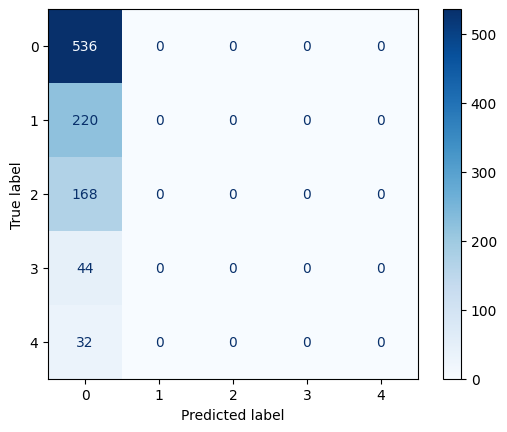

In [12]:
y_true = df_csv['Disease category'] - 1  # 將[1,2,3]轉換為[0,1,2]
y_pred = []
for id in training_id:
    mfccs_feature = audio_to_mfccs(df_csv[df_csv['ID']==id]['wav_path'].values[0])
    df = pd.DataFrame(mfccs_feature)

    frame_pred = model.predict(df)
    frame_pred_results = frame_pred.argmax(axis=1)

    person_pred = np.array([np.sum(frame_pred_results==0), np.sum(frame_pred_results==1), np.sum(frame_pred_results==2)]).argmax()  # 注意!如三類別相同票數，預測會為0

    y_pred.append(person_pred)

results_recall = recall_score(y_true, y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

# 驗證資料測試結果

12/12 [==============================] - 0s 728us/step
Test UAR(Unweighted Average Recall) : 0.2


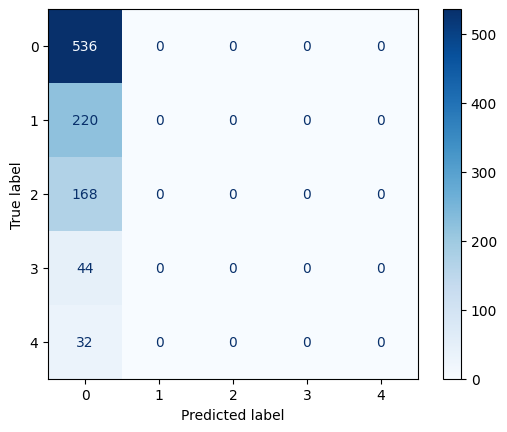

In [13]:
# model = load_model(MODEL_SAVE_NAME + ".h5")

y_true = df_csv['Disease category'] - 1  # 將[1,2,3]轉換為[0,1,2]
y_pred = []
for id in df_csv['ID'].tolist():
    mfccs_feature = audio_to_mfccs(df_csv[df_csv['ID']==id]['wav_path'].values[0])
    df = pd.DataFrame(mfccs_feature)

    frame_pred = model.predict(df)
    frame_pred_results = frame_pred.argmax(axis=1)

    person_pred = np.array([np.sum(frame_pred_results==0), np.sum(frame_pred_results==1), np.sum(frame_pred_results==2)]).argmax()  # 注意!如三類別相同票數，預測會為0

    y_pred.append(person_pred)
    # print(np.array([np.sum(frame_pred_results==0), np.sum(frame_pred_results==1), np.sum(frame_pred_results==2)]))
    # print(frame_pred)

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')